Homework 1 Problem 1: H atom reaction with ethane
==================

In [1]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math

from IPython.display import Image

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


Problem 1 A
--------

I looked up an ethane phase diagram to confirm that ethane is gas (I guess it is obvious it will be gas but I wanted to check)

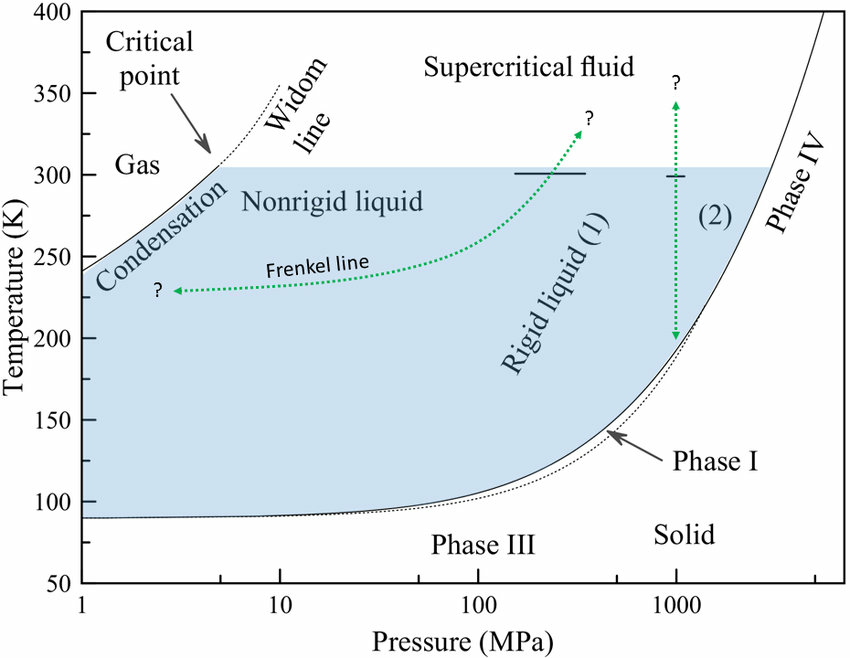

In [2]:
Image(filename='images/Ethane_phase_diagram.png') 

source: Observation of Liquid-Liquid Phase Transitions in Ethane at 300 K - Scientific Figure on ResearchGate.", Available from: https://www.researchgate.net/figure/Phase-diagram-of-ethane-The-liquid-gas-20-and-solid-liquid-31-transitions-are-shown_fig4_328321621", accessed 2 Sep, 2020\n",

In [3]:
# get chemkin file and setup reactor
cti_file = '/home/chrisb/Documents/grad school/2019/_08_Advanced_kinetics/assignments/HW1/propanepyrolysis.cti'
gas = ct.Solution(cti_file)

# 1 ppmv, if it is ideal gas, will just be molar ratio. therefor mole fractions will be:
X_H = 1/(1e6+1)
X_Eth = 1e6/(1e6+1)

# Reactor conditions
reactorTemperature = 1000  # Kelvin
reactorPressure = ct.one_atm
concentrations = {'H(2)': X_H, 'C2H6(36)': X_Eth}
gas.TPX = reactorTemperature, reactorPressure, concentrations 
H_conc = gas['H(2)'].concentrations
H_conc_half = H_conc/2
Eth_conc = gas['C2H6(36)'].concentrations

print(Eth_conc)
#initialize reactor, reactor network and sensitivities
atol = 1e-23
rtol = 1e-8
r1 = ct.ConstPressureReactor(contents=gas, energy='off', name='isothermal_reactor')

sim = ct.ReactorNet([r1])
sim.atol = atol
sim.rtol = rtol
print(gas.n_reactions)
for i in range(gas.n_reactions):
     r1.add_sensitivity_reaction(i)

#check initial concentration
print(*gas['H(2)','C2H6(36)'].X)
print(H_conc, H_conc_half)

[0.01218658]
668
9.99999000001e-07 0.999999000001
[1.21865849e-08] [6.09329247e-09]


In [4]:
# Run the reactor
time = 1
sim.reinitialize()

# make a second file for net rates of progress (kmol/M^3)
gas.net_rates_of_progress

# Create output files for sim that we can read in later:
outfile = open('results_ethane','w')
outfile2 = open('results_ethane_ROP','w')
outfile3 = open('results_sensitivity', 'w')
gas_production_label = [s + ' production rate' for s in gas.species_names]
gas_concentration_label = [s + ' concentration' for s in gas.species_names]
writer = csv.writer(outfile)
writer2 = csv.writer(outfile2)
writer3 = csv.writer(outfile3)
writer.writerow(['Time (s)'] + gas.species_names + gas_concentration_label + gas_production_label)
writer2.writerow(['Time (s)'] + gas.reactions())
writer3.writerow(['Time (s)'] + gas.reactions())

while sim.time < time:
    sim.step()
    writer.writerow([sim.time] + list(gas.X) + list(gas.concentrations)+list(gas.net_production_rates))
    writer2.writerow([sim.time] + list(gas.net_rates_of_progress))
    writer3.writerow([sim.time] + [sim.sensitivity('H(2)', s) for s in range(gas.n_reactions)])

In [5]:
# generate data frames
data = pd.read_csv('results_ethane')
df = pd.DataFrame(data)
data_rop = pd.read_csv('results_ethane_ROP')
df_rop = pd.DataFrame(data_rop)
data_sens = pd.read_csv('results_sensitivity')
df_sens = pd.DataFrame(data_sens)

##### problem 1.A.i #####
On what timescale does the mole fraction of H atoms drop (i.e. what is the half-life of an H atom in this system at these conditions)? <br>
Halflife of H radical is 4.37063658e-08 seconds

In [6]:
# Report find first concentration of H atom below 5e-7
timecol = df[df.columns[0]]
Hcol = df['H(2) concentration']

for i in range (0, len(timecol)):
    if Hcol[i] <= H_conc_half:
        # perform 2-point interpolation to get half life time
        y1 = timecol[i-1]
        y2 = timecol[i]
        x1 = Hcol[i-1]
        x2 = Hcol[i]
        t_halflife = ((y2-y1)/(x2-x1))*(H_conc_half-x1)+y1
        print(y1)
        print("Problem 1.A.i: Halflife of H radical is", t_halflife, "seconds")
        break
        


4.2738415131243565e-08
Problem 1.A.i: Halflife of H radical is [4.37063658e-08] seconds


##### problem 1.A.ii #####
Does the mole fraction of ethane change much on this short timescale? 

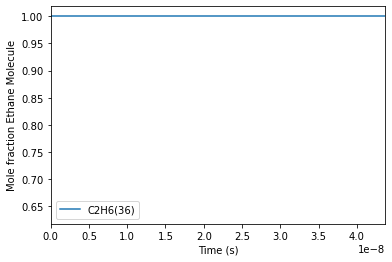

In [7]:
# problem 1.A.ii
# lets see. We'll set the max of the x-axis to t_halflife for the ethane mole fraction:
plt1 = data.plot(x='Time (s)', y='C2H6(36)')
plt1.set_xlim(0,t_halflife)
plt.ylabel('Mole fraction Ethane Molecule')
plt.xlabel('Time (s)')
plt.show()

it appears that it does not change very much from 0 to the half life time

##### problem 1.A.iii #####
What product species are being formed rapidly as the H atoms react, formed by what reaction? 

In [8]:
# add check to find species that go above a threshold value of mole fraction > 1E-3
imp_species = []
imp_reactions = []

print('These are all the species that report a value above the threshold of 1E-3 for their mole fraction:')
for i in range (1, len(gas.species_names)):
    
    column = df[df.columns[i]]
    time = df[df.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()

    if max_value > 1e-3:
        imp_species.append(df.columns[i])
        
        print(df.columns[i], "Max = " "{:.10f}".format(max_value), '  time = ', time[max_index])
        
# add a check for maximum rate of generation values. 
# is there a way to get net contributions of a reaction? 
print('\nThese are all the reactions that report ROP value above the threshold of 1E-4 kmol/m^3:')
for i in range (1, len(df_rop.columns)):
    
    column = df_rop[df_rop.columns[i]]
    time = df_rop[df.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()

    if max_value > 1e-5:
        imp_reactions.append(df_rop.columns[i])
        print(df_rop.columns[i], "Max = " "{:.10f}".format(max_value),'  time = ', time[max_index])
        

These are all the species that report a value above the threshold of 1E-3 for their mole fraction:
H2(6) Max = 0.1804343101   time =  0.9944080378672312
CH4(15) Max = 0.0032627765   time =  0.9944080378672312
C2H6(36) Max = 0.9999990000   time =  1.2027005745489235e-19
C2H4(38) Max = 0.1783716389   time =  0.9944080378672312

These are all the reactions that report ROP value above the threshold of 1E-4 kmol/m^3:
C2H6(36) + CH3(14) <=> C2H5(37) + CH4(15) Max = 0.0000403635   time =  0.4595911956193904
2 C2H5(37) <=> C2H4(38) + C2H6(36) Max = 0.0000119305   time =  0.011454287022464284
C2H6(36) + H(2) <=> C2H5(37) + H2(6) Max = 0.1935594657   time =  1.2027005745489235e-19
SC4H9(184) <=> C3H6(95) + CH3(14) Max = 0.0000143591   time =  1.0064442952804913
C2H4(38) + H(2) <=> C2H3(41) + H2(6) Max = 0.0000120473   time =  0.7730983431828595


it appears that we have the expected reaction occurring over our smaller timescale: 

C2H6(36) + H(2) <=> C2H5(37) + H2(6)

##### problem 1.A.iv #####
Plot the logarithm of H atom mole concentration versus time; is the plot linear at short times as expected 
if the H atom decay is exponential in time? (If the plot is linear, we call this a pseudo-first-order process; 
pseudo because the H atoms are actually participating in bimolecular reactions not decaying unimolecularly.). 

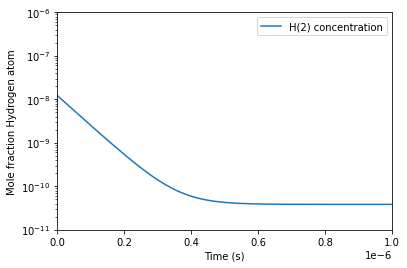

In [9]:
# plot H atom mole fraction on a log scale
plt1 = data.plot(x='Time (s)', y='H(2) concentration',logy=True)
plt1.set_ylim(1e-11,1e-6)
plt1.set_xlim(0,1e-6)
plt.ylabel('Mole fraction Hydrogen atom')
plt.xlabel('Time (s)')
plt.show()

The decay is linear on a log plot over short time scales. We'd expect this because the reaction is 
pseudo 1st order (our ethane concentration is essentially constant)

##### Problem 1.A.v #####
What happens at slightly longer times?

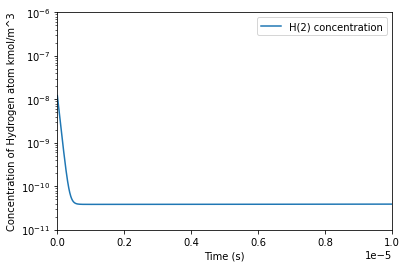

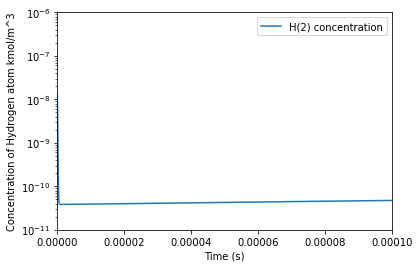

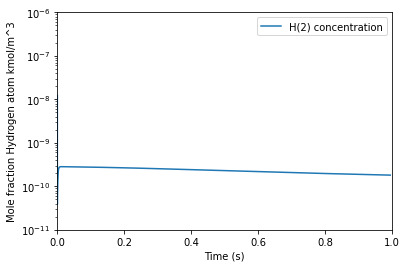

In [10]:
# plot concentrations at longer timescales: 1e-5 seconds, 1e-4s seconds, and 1 second

plt1 = data.plot(x='Time (s)', y='H(2) concentration', logy=True)
plt1.set_ylim(1e-11,1e-6)
plt1.set_xlim(0,1e-5)
plt.ylabel('Concentration of Hydrogen atom kmol/m^3')
plt.xlabel('Time (s)')
plt.show()

plt2 = data.plot(x='Time (s)', y='H(2) concentration', logy=True)
plt2.set_ylim(1e-11,1e-6)
plt2.set_xlim(0,1e-4)
plt.ylabel('Concentration of Hydrogen atom kmol/m^3')
plt.xlabel('Time (s)')
plt.show()

plt3 = data.plot(x='Time (s)', y='H(2) concentration', logy=True)
plt3.set_ylim(1e-11,1e-6)
plt3.set_xlim(0,1)
plt.ylabel('Mole fraction Hydrogen atom kmol/m^3')
plt.xlabel('Time (s)')
plt.show()

the H2 concentration, over longer time spans, actually increases slightly, 
then begins a second decay, as shown by the graphs above:

Problem 1 B
--------

##### Problem 1.B.i #####
Use ROP analysis during the very early times to confirm that the expected reaction is indeed responsible for
most of the loss of H atom.

I did this above in 1.A.iii, it appears that the reaction that has a ROP worth noting in the first 6e-7 seconds
(which is where our H atom decay appears to occurr) is <br>
C2H6(36) + H(2) <=> C2H5(37) + H2(6)

In [12]:
# get reactions with Highest ROP

print('\nThese are all the reactions that report ROP value above the threshold of 1E-5 kmol/m^3:', '\n')
for i in range (1, len(df_rop.columns)):
    
    column = df_rop[df_rop.columns[i]]
    time = df_rop[df.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()

    if max_value > 1e-5:
        imp_reactions.append(df_rop.columns[i])
        print(df_rop.columns[i], "Max = " "{:.10f}".format(max_value),'  time = ', time[max_index])


These are all the reactions that report ROP value above the threshold of 1E-5 kmol/m^3: 

C2H6(36) + CH3(14) <=> C2H5(37) + CH4(15) Max = 0.0000403635   time =  0.4595911956193904
2 C2H5(37) <=> C2H4(38) + C2H6(36) Max = 0.0000119305   time =  0.011454287022464284
C2H6(36) + H(2) <=> C2H5(37) + H2(6) Max = 0.1935594657   time =  1.2027005745489235e-19
SC4H9(184) <=> C3H6(95) + CH3(14) Max = 0.0000143591   time =  1.0064442952804913
C2H4(38) + H(2) <=> C2H3(41) + H2(6) Max = 0.0000120473   time =  0.7730983431828595


##### Problem 1.B.ii #####
If only this reaction matters, then one should be able to determine the rate coefficient k(T) of this key 
reaction from the half-life of the H atom (for example, if you measured the half-life for decay of H atoms 
experimentally.) Give the algebraic expression for k in terms of the half-life and the initial mole fractions 
and pressure. 

I found this equation on the web, used concentrations instead of mole fractions: 

https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Kinetics/Reaction_Rates/Second-Order_Reactions/Pseudo-1st-order_reactions

Website reference for equation: 

Chang, Raymond. Physical Chemistry for the Biosciences. Sausalito, California: University Science Books, 2005. Print.

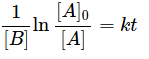

In [13]:
Image(filename='images/Pseudo_1st_Order.png')

In [14]:
# determine the rate constant via our t_halflife calculation
k_cantera = (((1/Eth_conc)*np.log(2)/t_halflife))/1000
print('rate constant from our calculations:', k_cantera, 'M^3/s*mol')

rate constant from our calculations: [1301363.86942814] M^3/s*mol


##### Problem 1.B.iii #####
If you plug in the value of the half-life from the plots of H vs. time, do you get a value for k(1000 K) 
that is consistent with the Arrhenius parameters for the key reaction given in the chem.inp file?

rate constant from chemkin input: 1303318 M^3/s mol<br>
rate constant from our calculations: 1301364 M^3/s mol<br>
error between the two: 0.14993071<br>

In [15]:
# below is the rate constant for the forward reaction
k_chemkin = gas.forward_rate_constants[25]/1000

print('reaction:', gas.reaction(25))
print('rate constant from chemkin input:', k_chemkin, 'M^3/s*mol')
print('rate constant from our calculations:', k_cantera, 'M^3/s*mol')

error_k = abs((k_chemkin-k_cantera)/k_chemkin)*100

print('error between the two:', error_k)

reaction: C2H6(36) + H(2) <=> C2H5(37) + H2(6)
rate constant from chemkin input: 1303317.94333364 M^3/s*mol
rate constant from our calculations: [1301363.86942814] M^3/s*mol
error between the two: [0.14993071]


Problem 1 C
--------

##### Problem 1.C.i #####

Use sensitivity analysis on this short time scale to confirm that the mole fraction of H atom at the t*=t(halflife) you are using is only sensitive to the k for the one key reaction, i.e. that your analysis in part (b) is sensible. 




These are all the reactions that report an average sensitivity value above the threshold of 1E-3: 

C2H4(38) + H(2) (+M) <=> C2H5(37) (+M) : 0.2172334275530264 MEAN
C2H4(38) + H(2) (+M) <=> C2H5(37) (+M) : 0.9724386620313092 MAX
C2H6(36) + H(2) <=> C2H5(37) + H2(6) : -1.5262181485452333 MEAN
C2H6(36) + H(2) <=> C2H5(37) + H2(6) : -3.7312807755434165 MIN


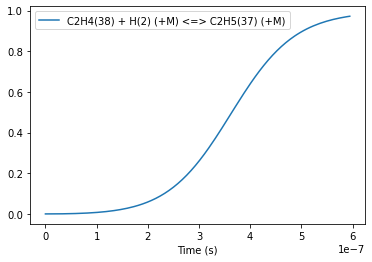

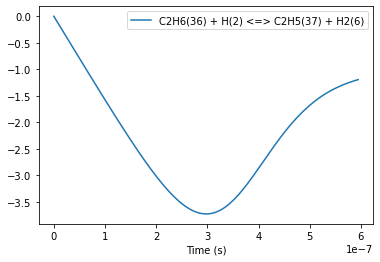

In [16]:
#calculate average sensitivity for all reactions from t=0 to t = 6e-7
print('\nThese are all the reactions that report an average sensitivity value above the threshold of 1E-3:', '\n')
time = df_sens[df_sens.columns[0]]


#shorten dataframe for t=0 to t = 6e-7
df_sens_short = df_sens[df_sens['Time (s)'] <= 6e-7]

sens_rxns=[]

for i in range (1, len(df_sens_short.columns)):
    column = df_sens_short[df_sens_short.columns[i]]
    column_mean_abs = abs(column.mean())
    
    if column_mean_abs > 1e-3:
        print(df_sens_short.columns[i], ':', column.mean(), 'MEAN')
        sens_rxns.append(df_sens_short.columns[i])
        
    if column.max() > 1e-3:
        print(df_sens_short.columns[i], ':', column.max(), 'MAX')
        if column_mean_abs <= 1e-3:
            sens_rxns.append(df_sens_short.columns[i])
        
    if column.min() < -1e-3:
        print(df_sens_short.columns[i], ':', column.min(), 'MIN')
        if column_mean_abs <= 1e-3:
            sens_rxns.append(df_sens_short.columns[i])

for i in range(len(sens_rxns)):
    df_sens_short.plot(x='Time (s)', y=sens_rxns[i])



Problem 1 D
--------

##### Problem 1.D.i #####
What happens at slightly longer times when the H atom mole fraction is no longer dropping rapidly? Use ROP analysis to see what reactions are turning on at these slightly longer times that stop the H atom concentration from continuing to drop. 




These are all the reactions that report ROP value above the threshold of 1E-5 kmol/m^3: 

C2H6(36) + CH3(14) <=> C2H5(37) + CH4(15) Max = 0.0000403635   time =  0.4595911956193904
2 C2H5(37) <=> C2H4(38) + C2H6(36) Max = 0.0000119305   time =  0.011454287022464284
C2H6(36) + H(2) <=> C2H5(37) + H2(6) Max = 0.1935594657   time =  1.2027005745489235e-19
SC4H9(184) <=> C3H6(95) + CH3(14) Max = 0.0000143591   time =  1.0064442952804913
C2H4(38) + H(2) <=> C2H3(41) + H2(6) Max = 0.0000120473   time =  0.7730983431828595


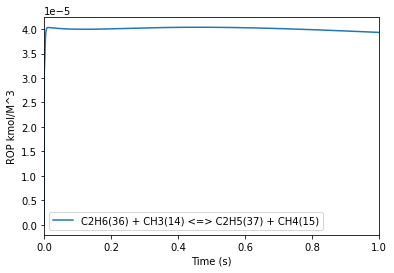

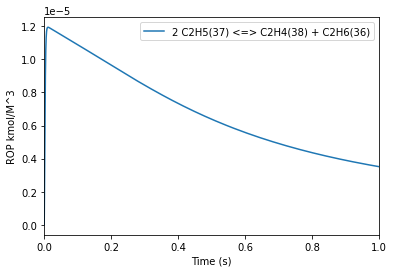

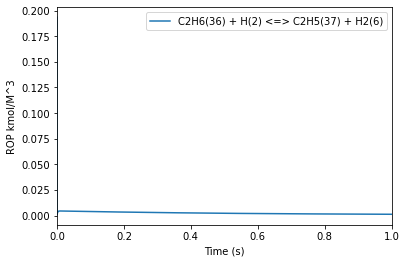

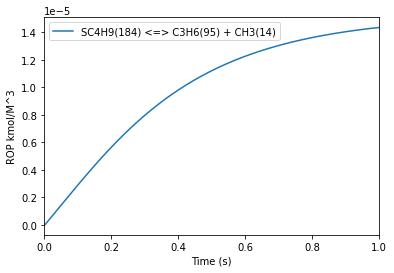

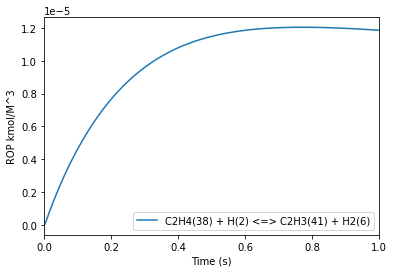

In [17]:
max_time = 1
imp_reactions = []

print('\nThese are all the reactions that report ROP value above the threshold of 1E-5 kmol/m^3:', '\n')
for i in range (1, len(df_rop.columns)):
    
    column = df_rop[df_rop.columns[i]]
    time = df_rop[df.columns[0]]
    max_value = column.max()
    max_index = column.idxmax()
    min_value = column.min()
    min_index = column.idxmin()

    if max_value > 1e-5:
        imp_reactions.append(df_rop.columns[i])
        print(df_rop.columns[i], "Max = " "{:.10f}".format(max_value),'  time = ', time[max_index])
        

# reactions
for i in range(len(imp_reactions)):
    df_rop.plot(x='Time (s)', y=imp_reactions[i],xlim=[0,max_time], ylabel='ROP kmol/M^3')


##### Problem 1.D.ii #####
Is the H atom concentration stabilizing towards a value set by an equilibrium or by a steady-state, or is 
something else happening? 
 

(0.0, 0.001)

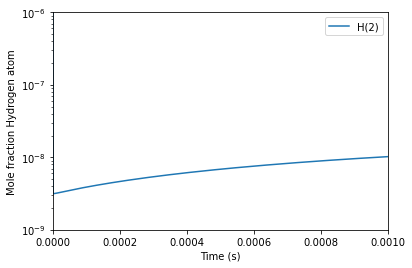

In [18]:
plt1 = data.plot(x='Time (s)', y='H(2)', xlabel='Time (s)', logy=True, ylabel='Mole fraction Hydrogen atom')
plt1.set_ylim(1e-9,1e-6)
plt1.set_xlim(0,1e-3)

The concentration of H is increasing slightly from a local minima at ~ 6e-7 seconds. it appears, after the minima, to be approaching an equilibrium value

##### Problem 1.D.ii #####

Does sensitivity analysis at this somewhat longer time identify the same important reactions as the ROP analysis?

Answer: 
There are some differences:

###### ROP analysis reactions: ######
C2H6(36) + CH3(14) <=> C2H5(37) + CH4(15) Max = 0.0000403635   time =  0.4595911956193904

2 C2H5(37) <=> C2H4(38) + C2H6(36) Max = 0.0000119305   time =  0.011454287022464284

C2H6(36) + H(2) <=> C2H5(37) + H2(6) Max = 0.1935594657   time =  1.2027005745489235e-19

SC4H9(184) <=> C3H6(95) + CH3(14) Max = 0.0000143591   time =  1.0064442952804913

C2H4(38) + H(2) <=> C2H3(41) + H2(6) Max = 0.0000120473   time =  0.7730983431828595

###### Sensitivity analysis reactions: ######
2 CH3(14) (+M) <=> C2H6(36) (+M) : 0.30194696126899984 MEAN

2 C2H5(37) <=> C2H4(38) + C2H6(36) : -0.18373809797330815 MEAN

C2H4(38) + H(2) (+M) <=> C2H5(37) (+M) : 0.6983304727886813 MEAN

C2H6(36) + H(2) <=> C2H5(37) + H2(6) : -0.9575305132033741 MEAN

C2H5(37) + C3H6(95) <=> C2H6(36) + C3H5-A(94) : 0.1054294647053752 MAX


These are all the reactions that report an average sensitivity value above the threshold of 1E-1: 

2 CH3(14) (+M) <=> C2H6(36) (+M) : 0.30194696126899984 MEAN
2 C2H5(37) <=> C2H4(38) + C2H6(36) : -0.18373809797330815 MEAN
C2H4(38) + H(2) (+M) <=> C2H5(37) (+M) : 0.6983304727886813 MEAN
C2H6(36) + H(2) <=> C2H5(37) + H2(6) : -0.9575305132033741 MEAN
C2H5(37) + C3H6(95) <=> C2H6(36) + C3H5-A(94) : 0.1054294647053752 MAX


'IC3H7(93) + propane(1) <=> NC3H7(92) + propane(1)'

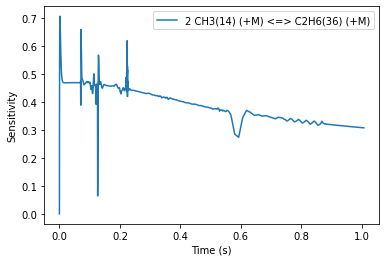

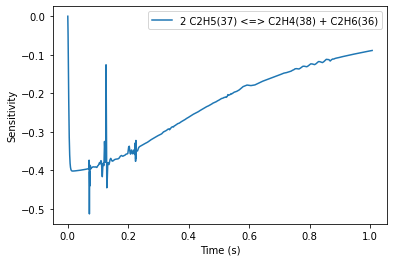

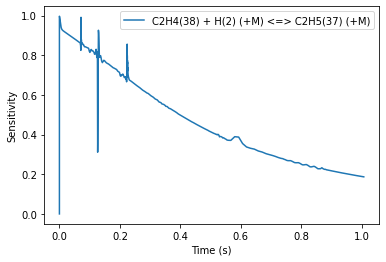

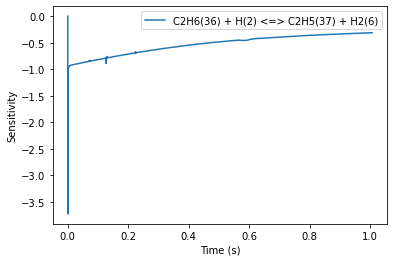

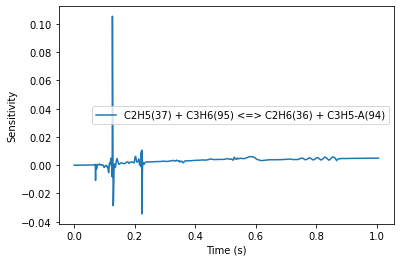

In [19]:
#calculate average sensitivity for all reactions from t = 0 to t = 1
print('\nThese are all the reactions that report an average sensitivity value above the threshold of 1E-1:', '\n')
time = df_sens[df_sens.columns[0]]

sens_rxns=[]

for i in range (1, len(df_sens.columns)):
    column = df_sens[df_sens.columns[i]]
    column_mean_abs = abs(column.mean())
    
    if column_mean_abs > 1e-1:
        print(df_sens.columns[i], ':', column.mean(), 'MEAN')
        sens_rxns.append(df_sens.columns[i])
        
    if column.max() > 1e-1:

        if column_mean_abs <= 1e-1:
            print(df_sens.columns[i], ':', column.max(), 'MAX')
            sens_rxns.append(df_sens.columns[i])
        
    if column.min() < -1e-1:

        if column_mean_abs <= 1e-1 and column.max() <= -1e-1:
            print(df_sens.columns[i], ':', column.min(), 'MIN')
            sens_rxns.append(df_sens.columns[i])

for i in range(len(sens_rxns)):
    df_sens.plot(x='Time (s)', y=sens_rxns[i], ylabel = 'Sensitivity')

df_sens.columns[i]
# for one second it identifies quite a few more, most seeing a spike around 0.1 s